
#### German Sokolov

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
plt.style.use("ggplot")
%matplotlib inline

There are two parts of one dataset - students who take either **Math (395 obs) or Portuguese (649 obs) course**.

In [2]:
# Create separate dataframes for both datasets (Portuguese and Math course)
df_mat = pd.read_csv("student-mat.csv", sep = ";")
print ("There are {} observations in dataset".format(df_mat.shape[0]))
df_por = pd.read_csv("student-por.csv", sep = ";")
print ("There are {} observations in dataset".format(df_por.shape[0]))

There are 395 observations in dataset
There are 649 observations in dataset


Take a look at any of them:

In [3]:
df_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Let's create new variable to identify which course the students belong to:

In [4]:
# If Math course, "class" = 1, otherwise = 0
df_mat["class"] = 1
df_por["class"] = 0

The description of dataset states that there are **duplicate observations** in datasets, i.e. students can **visit both** classes. It is unnecessary to hold the duplicates as they have the same values of attributes, except for grades ("G1", "G2, "G3") and "absences".

In [5]:
# The subset of columns which unambiguously identifies unique students:
uniq_attr = ["school", "sex", "age", "address", "famsize", "Pstatus", "Medu",
             "Fedu", "Mjob", "Fjob", "reason", "guardian", "nursery", "internet",
             "schoolsup", "famsup", "activities", "romantic", "famrel", "goout",
             "health"]
print("Number of duplicates ind dataset -", 
      df_mat.duplicated(subset = uniq_attr, keep = False).sum())
print("Number of duplicates ind dataset -", 
      df_por.duplicated(subset = uniq_attr, keep = False).sum())

Number of duplicates ind dataset - 0
Number of duplicates ind dataset - 4


The number of duplicates should be zero for both datasets, if taking the subset of unique attribures. It is true for Math course, but there are 4 potential duplicates in Portuguese course dataframe. It is strange, but take a closer look at them:

In [6]:
ind_dupl_por = df_por.duplicated(subset = uniq_attr, keep = False)
df_por.loc[ind_dupl_por, :]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,class
442,MS,M,15,R,LE3,T,4,1,health,services,...,3,4,1,2,2,0,12,13,14,0
443,MS,M,15,R,LE3,T,4,1,health,services,...,3,4,1,2,2,7,7,9,8,0
453,MS,F,16,U,GT3,T,1,2,other,services,...,3,2,1,2,4,0,10,8,8,0
454,MS,F,16,U,GT3,T,1,2,other,services,...,3,2,1,2,4,3,9,8,8,0


Amazingly these 4 observations differ only in Grades and Absences attributes, but still they are different objects. Firstly, let's check them separately - whether any of these 4 students also visit Math course or not. However, it turns out that the 4 students visit only course of Portuguese.

In [7]:
df_por_dup = df_por.loc[ind_dupl_por,:]
df_temp = pd.concat([df_por_dup, df_mat], ignore_index= True)
print("Number of duplicates ind dataset -", 
      df_temp.duplicated(subset = uniq_attr, keep = False).sum())

Number of duplicates ind dataset - 4


There are **370** "real" duplicate observations - people who attend both courses.

In [8]:
df_all = pd.concat([df_mat, df_por.loc[~ind_dupl_por,:]], ignore_index=True)
ind = df_all.duplicated(subset = uniq_attr, keep = False)
df_all.loc[ind, "class"].value_counts()

1    370
0    370
Name: class, dtype: int64

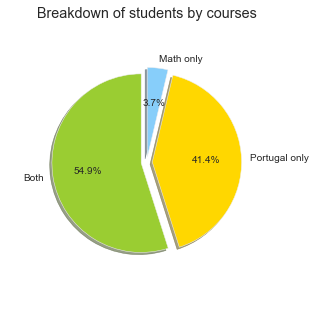

In [9]:
# Remove the duplicated students and leave the math grades:
df_all = df_all.loc[~((ind) & (df_all["class"] == 0))]
df_all.loc[(ind) & (df_all["class"] == 1), "class"] = 2
df_all = pd.concat([df_all, df_por_dup], ignore_index=True)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.pie(df_all["class"].value_counts(), explode = (0.05, 0.05, 0.05),
        colors = ['yellowgreen', 'gold', 'lightskyblue'], 
        labels=["Both", "Portugal only", 'Math only'], 
        shadow=True, startangle=90, center=(0, 0), radius= 0.8,
        autopct='%1.1f%%')
ax.set_aspect("equal")
plt.title("Breakdown of students by courses")

There is no point to have separate value to denote students who visit *only* math class, because this group consists of only 25 students. Instead, denote by 0 those, who visit only Portuguese course and denote by 1 the others.

In [10]:
df_all.loc[(ind) & (df_all["class"] == 2), "class"] = 1
df_all["class"].value_counts()

1    395
0    279
Name: class, dtype: int64

The target value is 2-dimensional (workday and weekend consumption), which leads to multiple output problem. The histogram reveals, that students tend to drink more on weekends:

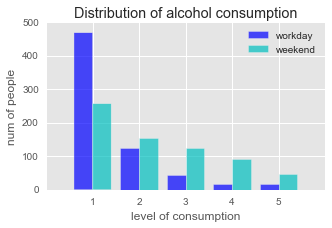

In [11]:
plt.figure(figsize=(5,3))
plt.hist([df_all.Dalc.values, df_all.Walc.values], 
         bins = np.arange(1, 7) - 0.5,
         color = ["b", "c"], align = "mid", alpha = 0.7)

plt.title("Distribution of alcohol consumption")
plt.xticks(np.arange(1, 6))
plt.legend(["workday", "weekend"])
plt.xlabel("level of consumption")
plt.ylabel("num of people")

The Pearson correlation is significant, but not absolute:

In [12]:
df_all[["Dalc", "Walc"]].corr()

,Dalc,Walc
Dalc,1.000000,0.613915
Walc,0.613915,1.000000


Many attributes are nominal, let's use LabelEncoder to convert them into factors. The grades can be incorporated into one attribute (by taking average):

In [13]:
# nominal attributes:
cols_to_transform = ["school", "sex", "address", "famsize", "Pstatus", 
                     "Mjob", "Fjob", "reason", "guardian", "schoolsup", 
                     "famsup", "paid", "activities", "nursery", "higher", 
                     "internet", "romantic"]
labels = []
le = preprocessing.LabelEncoder()
for col in cols_to_transform:
    df_all[col] = le.fit_transform(df_all[col])
    labels.append(list(le.classes_))

df_all['G_aver'] = df_all[["G1", "G2", "G3"]].mean(axis = 1)
df_all.drop(["G1", "G2", "G3"], axis = 1, inplace = True)
df_all.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,class,G_aver
0,0,0,18,1,0,0,4,4,0,4,...,0,4,3,4,1,1,3,6,1,5.666667
1,0,0,17,1,0,1,1,1,0,2,...,0,5,3,3,1,1,3,4,1,5.333333
2,0,0,15,1,1,1,1,1,0,2,...,0,4,3,2,2,3,3,10,1,8.333333
3,0,0,15,1,0,1,4,2,1,3,...,1,3,2,2,1,1,5,2,1,14.666667
4,0,0,16,1,0,1,3,3,2,2,...,0,4,3,2,1,2,5,4,1,8.666667


Let's make more graphs!

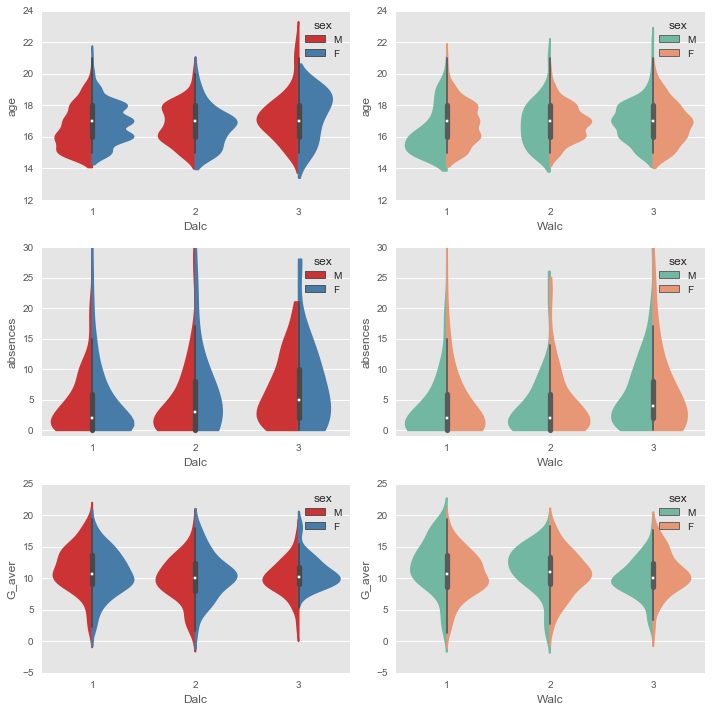

In [14]:
pd.options.mode.chained_assignment = None
df_viol = df_all[['age', 'sex', 'absences', 'G_aver', 'Dalc', 'Walc']]
# Combine Dalc and Walc levels >= 3 into single level 3:
df_viol.loc[df_all.Dalc.isin([3, 4, 5]), 'Dalc'] = 3
df_viol.loc[df_all.Walc.isin([3, 4, 5]), 'Walc'] = 3
le.classes_ = np.array(labels[1], dtype='<U9')
df_viol['sex'] = le.inverse_transform(df_viol.sex)

plt.figure(figsize=(10,10))
plt.subplot(3, 2, 1)
sns.violinplot(x = 'Dalc', y = 'age', hue = 'sex', hue_order=["M", "F"],
               data = df_viol, split=True, palette="Set1")
plt.subplot(3, 2, 2)
sns.violinplot(x = 'Walc', y = 'age', hue = 'sex', hue_order=["M", "F"], 
               data = df_viol, split=True, palette="Set2")

plt.subplot(3, 2, 3)
sns.violinplot(x = 'Dalc', y = 'absences', hue = 'sex', hue_order=["M", "F"],
               data = df_viol, split=True, palette="Set1", cut = 0)
plt.ylim([-1, 30])

plt.subplot(3, 2, 4)
sns.violinplot(x = 'Walc', y = 'absences', hue = 'sex', hue_order=["M", "F"], 
               data = df_viol, split=True, palette="Set2", cut = 0)
plt.ylim([-1, 30])

plt.subplot(3, 2, 5)
sns.violinplot(x = 'Dalc', y = 'G_aver', hue = 'sex', hue_order=["M", "F"], 
               data = df_viol, split=True, palette="Set1")

plt.subplot(3, 2, 6)
sns.violinplot(x = 'Walc', y = 'G_aver', hue = 'sex', hue_order=["M", "F"], 
               data = df_viol, split=True, palette="Set2")

plt.tight_layout()

Several facts can be observed from the vilin-plots:
 * Age seems to have small affect on level of alcohol consumption
 * Absences positively affects Dalc and Walc
 * Average grades are negatively related with target varables

Now let's find appropriate model and optimal parameters to fit the data.

In [15]:
y = df_all[["Dalc", "Walc"]]
df_all.drop(["Dalc", "Walc"], axis = 1, inplace=True)
X = df_all

For this problem take into account 3 models - *DecisionTree regressor, EatraTrees regressor and Ridge regression*. The max number of features is 10 so let's take only the most important using **SelectFromModel** sklearn function. For parameters tuning we can use **GridsearchCV** due to small sample size. The number of folds in cross-validation is set to 10.

In [16]:
labels = ["DecisionTree", "ExtraTrees", "Ridge"]
regressors = [DecisionTreeRegressor(), ExtraTreesRegressor(), Ridge()]
params_dtr = {'max_depth': list(range(2, 8)), 
              'min_samples_leaf': list(range(2,20))
             }
params_etr = {'n_estimators': [10, 20, 50, 100],
              'max_depth': list(range(2, 8)),
              'min_samples_leaf': list(range(2,20))
              }
params_ridge = {'alpha': np.arange(0, 80)}
params_gs = [params_dtr, params_etr, params_ridge]

for r in regressors:
    ind = regressors.index(r)
    print(labels[ind])
    sfm = SelectFromModel(r)
    sfm.fit(X, y)
    n_features = sfm.transform(X).shape[1]
    print("N_features -", n_features, list(X.columns[sfm.get_support()]))
    gs = GridSearchCV(r, param_grid = params_gs[ind], 
                      cv = 10, scoring='mean_squared_error')
    X_sc = preprocessing.scale(sfm.transform(X))
    gs.fit(X_sc, y)
    print('Parameters:', gs.best_params_)
    print('Best mean MSE:', abs(gs.best_score_), "\n")

DecisionTree
N_features - 8 ['sex', 'reason', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G_aver']
Parameters: {'max_depth': 3, 'min_samples_leaf': 10}
Best mean MSE: 0.994415139552 

ExtraTrees
N_features - 9 ['sex', 'age', 'studytime', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G_aver']
Parameters: {'n_estimators': 10, 'max_depth': 6, 'min_samples_leaf': 10}
Best mean MSE: 0.944894307808 

Ridge
N_features - 10 ['sex', 'famsize', 'Pstatus', 'guardian', 'studytime', 'schoolsup', 'paid', 'nursery', 'famrel', 'goout']
Parameters: {'alpha': 35}
Best mean MSE: 0.963295896644 



The best MSE is provided by ExtraTrees regressor model.